In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import discreteaction_pendulum
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt

batch_size = 64
gamma = 0.95
eps_start = 1
eps_end = 0.1

In [11]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_states, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64,n_actions)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = self.out(x)
        return x 

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def eps_decay(itr,num_episodes):
    if itr>=num_episodes*100:
        return eps_end
    else:
        return (eps_end - eps_start)*itr/(num_episodes*100) + eps_start

In [13]:
env = discreteaction_pendulum.Pendulum()

In [14]:
n_actions = env.num_actions
n_states = env.num_states

In [15]:
policy_net = DQN(n_states, n_actions)
target_net = DQN(n_states, n_actions)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [16]:
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000)

In [17]:
def action(state):
    p = np.random.random()
    if p < eps:
        a = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    else:
        a = policy_net(state).max(1)[1].view(1, 1)
        
    return a

In [18]:
def update_network():
    if len(memory) < batch_size:
        return

    batch_data = memory.sample(batch_size)

    batch = Transition(*zip(*batch_data))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)


    Q_s_a = policy_net(state_batch).gather(1, action_batch)

    y_js = torch.zeros(batch_size)

    with torch.no_grad():
        for i in range(batch_size):
            if batch.done[i]:
                y_js[i] = reward_batch[i]
            else:
                y_js[i] = reward_batch[i] + gamma*target_net(next_state_batch[i]).max()

    criterion = nn.MSELoss()

    loss = criterion(Q_s_a, y_js.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [19]:
num_episodes = 100

reward_array = np.zeros(num_episodes)

itr = 0

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    s = env.reset()
    s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    done = False
    time = 0
    while not done:
        eps = eps_decay(itr,num_episodes)
        a = action(s)
        s_next, r, done = env.step(a.item())
        r = torch.tensor([r])
        
        reward_array[i_episode] += gamma**(time)*r
        
        time += 1
        
        s_next = torch.tensor(s_next, dtype=torch.float32).unsqueeze(0)
        

        memory.push(s, a, s_next, r, done)

        # Move to the next state
        s = s_next

        # Perform one step of the optimization (on the policy network)
        update_network()
        
        itr+=1
        
        if itr%1000 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
#         target_net_state_dict = target_net.state_dict()
#         policy_net_state_dict = policy_net.state_dict()
#         for key in policy_net_state_dict:
#             target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
#         target_net.load_state_dict(target_net_state_dict)

10000

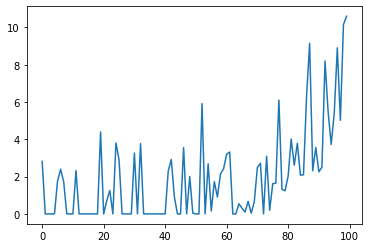

In [20]:
plt.plot(reward_array)
#plt.ylim(0,100)
itr

In [37]:
x = torch.tensor([-1,3])
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
torch.max(policy_net(x)).item()

/var/folders/dt/pgvlk7nn3sz86f4g6dg_mgrm0000gn/T/ipykernel_10275/4166294864.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)


3.528278350830078

In [21]:
policy = lambda s: (policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0)).max(1)[1].view(1, 1)).item()

In [22]:
env.video(policy, filename='figures/test_discreteaction_pendulum_2.gif')

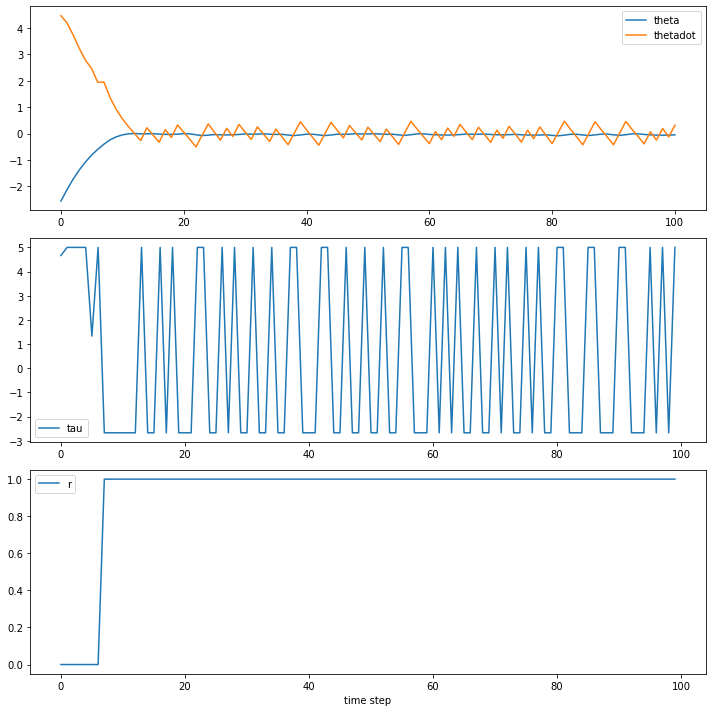

In [62]:
s = env.reset()

# Create dict to store data from simulation
data = {
    't': [0],
    's': [s],
    'a': [],
    'r': [],
}

# Simulate until episode is done
done = False
while not done:
    a = policy(s)
    (s, r, done) = env.step(a)
    data['t'].append(data['t'][-1] + 1)
    data['s'].append(s)
    data['a'].append(a)
    data['r'].append(r)

# Parse data from simulation
data['s'] = np.array(data['s'])
theta = data['s'][:, 0]
thetadot = data['s'][:, 1]
tau = [env._a_to_u(a) for a in data['a']]

# Plot data and save to png file
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(data['t'], theta, label='theta')
ax[0].plot(data['t'], thetadot, label='thetadot')
ax[0].legend()
ax[1].plot(data['t'][:-1], tau, label='tau')
ax[1].legend()
ax[2].plot(data['t'][:-1], data['r'], label='r')
ax[2].legend()
ax[2].set_xlabel('time step')
plt.tight_layout()
plt.savefig('figures/test_discreteaction_pendulum_1.png')

In [39]:
from matplotlib.colors import LogNorm
from pylab import meshgrid

(121, 201)
(120,)
(200,)


/var/folders/dt/pgvlk7nn3sz86f4g6dg_mgrm0000gn/T/ipykernel_10275/2407393991.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s1 = torch.tensor(s, dtype=torch.float32).unsqueeze(0)


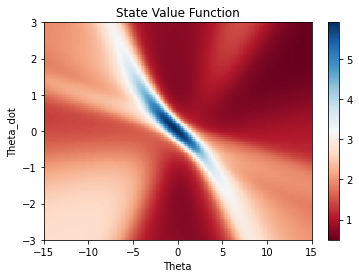

In [74]:
dx, dy = 0.15, 0.05

def value_fun(policy_net, x, y):
    s = torch.tensor([x,y])
    s1 = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    return torch.mean(policy_net(s1)).item()

# x = np.arange(-3.0,3.0,0.1)
# y = np.arange(-15.0,15.0,0.1)
# X,Y = meshgrid(x, y) # grid of point
# Z = value_fun(policy_net, X, Y) # evaluation of the function on the grid

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[-3:3+dy:dy, -15:15+dx:dx]
X = np.arange(-3,3,dy)
Y = np.arange(-15,15,dx)
z = np.zeros(y.shape)
print(z.shape)
print(X.shape)
print(Y.shape)

for i in range(len(X)):
    for j in range(len(Y)):
        z[i,j] = value_fun(policy_net,X[i],Y[j])
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.min(z), np.max(z)

fig, ax = plt.subplots(1,1)

c = ax.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('State Value Function')
ax.set_xlabel("Theta")
ax.set_ylabel("Theta_dot")
fig.colorbar(c, ax=ax)
plt.savefig('figures/state_value_fun.png')

(121, 201)
(120,)
(200,)


/var/folders/dt/pgvlk7nn3sz86f4g6dg_mgrm0000gn/T/ipykernel_10275/1243508050.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  policy = lambda s: (policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0)).max(1)[1].view(1, 1)).item()


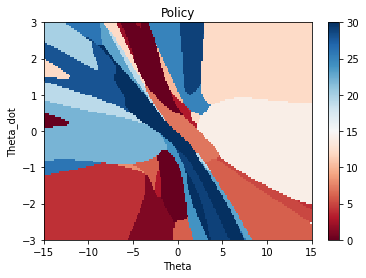

In [73]:
dx, dy = 0.15, 0.05

def value_fun(policy_net, x, y):
    s = torch.tensor([x,y])
    s1 = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    return torch.max(policy_net(s1)).item()

# x = np.arange(-3.0,3.0,0.1)
# y = np.arange(-15.0,15.0,0.1)
# X,Y = meshgrid(x, y) # grid of point
# Z = value_fun(policy_net, X, Y) # evaluation of the function on the grid

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[-3:3+dy:dy, -15:15+dx:dx]
X = np.arange(-3,3,dy)
Y = np.arange(-15,15,dx)
z = np.zeros(y.shape)
print(z.shape)
print(X.shape)
print(Y.shape)

for i in range(len(X)):
    for j in range(len(Y)):
        s = torch.tensor([X[i],Y[j]])
        #s1 = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
        z[i,j] = policy(s)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.min(z), np.max(z)

fig, ax = plt.subplots(1,1)

c = ax.pcolor(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Policy')
ax.set_xlabel("Theta")
ax.set_ylabel("Theta_dot")
fig.colorbar(c, ax=ax)

In [16]:
# torch.save(policy_net.state_dict(), "latest_good_network_1")

In [10]:
policy_net.load_state_dict(torch.load("latest_good_network"))

<All keys matched successfully>

In [11]:
policy_net

DQN(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=31, bias=True)
)

MovieWriter imagemagick unavailable; using Pillow instead.


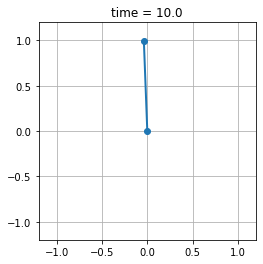

In [12]:
import matplotlib.animation as animation

s = env.reset()
s_traj = [s]
done = False
while not done:
    s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    (s, r, done) = env.step(policy_net(s).max(1)[1].view(1, 1).item())
    s_traj.append(s)

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.set_aspect('equal')
ax.grid()
line, = ax.plot([], [], 'o-', lw=2)
text = ax.set_title('')

def animate(i):
    theta = s_traj[i][0]
    line.set_data([0, -np.sin(theta)], [0, np.cos(theta)])
    text.set_text(f'time = {i * env.dt:3.1f}')
    return line, text

anim = animation.FuncAnimation(fig, animate, len(s_traj), interval=(1000 * env.dt), blit=True, repeat=False)
anim.save("Pendulum_1.gif", writer='imagemagick', fps=10)